In [0]:
import math
import io
import os
import time
import datetime
import csv
import re

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import operator
import pandas as pd

from io import open
from collections import namedtuple
from sklearn import tree
from tqdm import tqdm

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import learn



In [0]:
import pandas as pd
pd.options.display.max_rows = 500
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

## Training a Sentiment network (3 conv layers (for bigrams, trigrams and quadgrams) + 1 fully connected)



In [0]:
#Yoon Kim's Convolutional Neural Networks for Sentence Classification paper, implemented in Tensorflow by Denny Britz, mostly copied from his Github repo.
# This uses some different settings than the paper, like learning embeddings instead of using word2vec (or using both), using another dataset, not SST (Stanford Sentiment Treebank), not having L2 regularization.
# TODO - Add options for those settings as well, making it more faithful to the paper.

#Fix for flags
tf.app.flags.DEFINE_string('f', '', 'kernel')

#Dataset info
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polaritydata/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polaritydata/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 100, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS

In [0]:
#DOWNLOADING DATASET

!mkdir ./data/
!mkdir ./data/rt-polaritydata/
!wget https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/data/rt-polaritydata/rt-polarity.pos -O ./data/rt-polaritydata/rt-polarity.pos
!wget https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/data/rt-polaritydata/rt-polarity.neg -O ./data/rt-polaritydata/rt-polarity.neg

--2019-05-01 06:08:05--  https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/data/rt-polaritydata/rt-polarity.pos
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/Textual_Invariants/data/rt-polaritydata/rt-polarity.pos [following]
--2019-05-01 06:08:11--  https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/Textual_Invariants/data/rt-polaritydata/rt-polarity.pos
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626395 (612K) [text/plain]
Saving to: ‘./data/rt-polaritydata/rt-polarity.pos’

./data/rt-polarityd 100%[=========

In [0]:
#READ AND PROCESS INPUTS

def clean_str(string):
  """
  Tokenization/string cleaning for all datasets except for SST.
  Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
  """
  string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
  string = re.sub(r"\'s", " \'s", string)
  string = re.sub(r"\'ve", " \'ve", string)
  string = re.sub(r"n\'t", " n\'t", string)
  string = re.sub(r"\'re", " \'re", string)
  string = re.sub(r"\'d", " \'d", string)
  string = re.sub(r"\'ll", " \'ll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " \( ", string)
  string = re.sub(r"\)", " \) ", string)
  string = re.sub(r"\?", " \? ", string)
  string = re.sub(r"\s{2,}", " ", string)
  return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
  """
  Loads MR polarity data from files, splits the data into words and generates labels.
  Returns split sentences and labels.
  """
  # Load data from files
  positive_examples = list(open(positive_data_file, "r", encoding='utf-8').readlines())
  positive_examples = [s.strip() for s in positive_examples]
  negative_examples = list(open(negative_data_file, "r", encoding='utf-8').readlines())
  negative_examples = [s.strip() for s in negative_examples]
  # Split by words
  x_text = positive_examples + negative_examples
  x_text = [clean_str(sent) for sent in x_text]
  # Generate labels
  positive_labels = [[0, 1] for _ in positive_examples]
  negative_labels = [[1, 0] for _ in negative_examples]
  y = np.concatenate([positive_labels, negative_labels], 0)
  return [x_text, y]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
  """
  Generates a batch iterator for a dataset.
  """
  data = np.array(data)
  data_size = len(data)
  num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
  for epoch in range(num_epochs):
    # Shuffle the data at each epoch
    if shuffle:
      shuffle_indices = np.random.permutation(np.arange(data_size))
      shuffled_data = data[shuffle_indices]
    else:
      shuffled_data = data
    for batch_num in range(num_batches_per_epoch):
      start_index = batch_num * batch_size
      end_index = min((batch_num + 1) * batch_size, data_size)
      yield shuffled_data[start_index:end_index]

def preprocess():
  # Data Preparation
  # ==================================================

  # Load data
  print("Loading data...")
  x_text, y = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)
  print x_text[:2]
  # Build vocabulary
  max_document_length = max([len(x.split(" ")) for x in x_text])
  vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
  x = np.array(list(vocab_processor.fit_transform(x_text)))

  # Randomly shuffle data
  np.random.seed(10)
  shuffle_indices = np.random.permutation(np.arange(len(y)))
  x_shuffled = x[shuffle_indices]
  y_shuffled = y[shuffle_indices]
  x_text_shuffled = [x_text[i] for i in list(shuffle_indices)]
  #print shuffle_indices

  # Split train/test set
  # TODO: This is very crude, should use cross-validation
  dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
  x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
  y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
  x_text_train, x_text_dev = x_text_shuffled[:dev_sample_index], x_text_shuffled[dev_sample_index:]

  del x, y, x_shuffled, y_shuffled

  print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
  print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
  return x_train, y_train, vocab_processor, x_dev, y_dev, x_text_train, x_text_dev

x_train, y_train, vocab_processor, x_test, y_test, x_text_train, x_text_test = preprocess()

Loading data...
[u"the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal", u"the gorgeously elaborate continuation of the lord of the rings trilogy is so huge that a column of words cannot adequately describe co writer director peter jackson 's expanded vision of j r r tolkien 's middle earth"]
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Vocabulary Size: 18758
Train/Dev split: 9596/1066


In [0]:
x_validation = x_train[int(0.85*len(x_train)):]
x_text_validation = x_text_train[int(0.85*len(x_train)):]
x_train = x_train[:int(0.85*len(x_train))]
x_text_train = x_text_train[:int(0.85*len(x_train))]
y_validation = y_train[int(0.85*len(y_train)):]
y_train = y_train[:int(0.85*len(y_train)):]

In [0]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

#TODO Names are from the original implementation, may need to update them
def create_model(sequence_length, num_classes, vocab_size,
  embedding_size, filter_sizes, num_filters):
  
  # Placeholders for input, output and dropout
  input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
  input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
  dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

  # Embedding layer
  # tf.name_scope("embedding")
  with tf.device('/cpu:0'):
    W = tf.Variable(
      tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
      name="W_embed")
    embedded_chars = tf.nn.embedding_lookup(W, input_x)
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)

  # Create a convolution + maxpool layer for each filter size
  pooled_outputs = []
  relu_layers = []
  for i, filter_size in enumerate(filter_sizes):
    #with tf.name_scope("conv-maxpool-%s" % filter_size):
    # Convolution Layer
    filter_shape = [filter_size, embedding_size, 1, num_filters]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W_{}".format(filter_size))
    b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b_{}".format(filter_size))
    conv = tf.nn.conv2d(
      embedded_chars_expanded,
      W,
      strides=[1, 1, 1, 1],
      padding="VALID",
      name="conv_{}".format(filter_size))
    # Apply nonlinearity
    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu_{}".format(filter_size))
    relu_layers.append(h)
    # Maxpooling over the outputs
    pooled = tf.nn.max_pool(
      h,
      ksize=[1, sequence_length - filter_size + 1, 1, 1],
      strides=[1, 1, 1, 1],
      padding='VALID',
      name="pool_{}".format(filter_size))
    pooled_outputs.append(pooled)

  # Combine all the pooled features
  num_filters_total = num_filters * len(filter_sizes)
  h_pool = tf.concat(pooled_outputs, 3)
  h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total], 'h_pool_flat')

  # Add dropout
  with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

  # Final (unnormalized) scores and predictions
  #with tf.name_scope("output"):
  W1 = tf.get_variable(
    "W_fc1",
    shape=[num_filters_total, num_filters],
    initializer=tf.contrib.layers.xavier_initializer())
  b1 = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b_fc1")
  t_hidden = tf.nn.relu(tf.nn.xw_plus_b(h_drop, W1, b1, name="hidden"))
  W2 = tf.get_variable(
    "W_fc2",
    shape=[num_filters, num_classes],
    initializer=tf.contrib.layers.xavier_initializer())
  b2 = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b_fc2")
  logits = tf.nn.xw_plus_b(t_hidden, W2, b2, name="logits")
  probs = tf.nn.softmax(logits, axis=1, name='probs')
  predictions = tf.argmax(logits, 1, name="predictions")

  # Accuracy
  with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(predictions, tf.argmax(input_y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

  # Loss  
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y, logits=logits))
  
  return cross_entropy, accuracy, input_x, embedded_chars, dropout_keep_prob, logits, probs, input_y, relu_layers, pooled_outputs
  

### Train a new model

In [0]:
EMB_DIMS = 64
NUM_FILTERS = 64

tf.reset_default_graph()
sess = tf.InteractiveSession()
cross_entropy, accuracy, x, x_embedded, keep_prob, y_logits, y_probs,  y_, relu_layers, pooled_outputs = create_model(sequence_length=x_train.shape[1],
        num_classes=y_train.shape[1],
        vocab_size=len(vocab_processor.vocabulary_),
        embedding_size=EMB_DIMS,
        filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
        num_filters=NUM_FILTERS)
train_step = tf.train.AdamOptimizer(5e-4).minimize(cross_entropy)
saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
sess.run(tf.global_variables_initializer())

# Generate batches
batches = batch_iter(
  list(zip(x_train, y_train)), FLAGS.batch_size, num_epochs=50)
for i,batch in enumerate(batches):
  x_batch, y_batch = zip(*batch)
  _, batch_ce = sess.run([train_step, cross_entropy], feed_dict={x: x_batch, y_: y_batch, keep_prob: FLAGS.dropout_keep_prob})
  if i%200 == 0 and i > 0:
    validation_accuracy = accuracy.eval(feed_dict={
        x:x_validation, y_: y_validation, keep_prob: 1.0})
    print("step %d, batch CE %g, validation accuracy %g"%(i, batch_ce, validation_accuracy))    
    ckpt_path_name = saver.save(sess, './checkpoints/text_invariant.ckpt', global_step=i)
    print "Checkpoint saved at: %s" % ckpt_path_name

/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 200, batch CE 0.776882, validation accuracy 0.516667
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-200
step 400, batch CE 0.748258, validation accuracy 0.516667
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-400
step 600, batch CE 0.682527, validation accuracy 0.525
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-600
step 800, batch CE 0.681422, validation accuracy 0.523611
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-800
step 1000, batch CE 0.685394, validation accuracy 0.540278
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-1000
step 1200, batch CE 0.689072, validation accuracy 0.559722
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-1200
step 1400, batch CE 0.673377, validation accuracy 0.606944
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-1400
step 1600, batch CE 0.655242, validation accuracy 0.616667
Checkpoint saved at: ./checkpoints/text_invariant.ckpt-1600
step 1800, batch CE 0.600713, validation accuracy 0.620833


KeyboardInterrupt: ignored

In [0]:
!ls -l ./checkpoints/

total 163904
-rw-r--r-- 1 root root      325 Apr 29 21:04 checkpoint
-rw-r--r-- 1 root root 15148064 Apr 29 21:04 text_invariant.ckpt-2600.data-00000-of-00001
-rw-r--r-- 1 root root     1221 Apr 29 21:04 text_invariant.ckpt-2600.index
-rw-r--r-- 1 root root    98501 Apr 29 21:04 text_invariant.ckpt-2600.meta
-rw-r--r-- 1 root root 15148064 Apr 29 21:04 text_invariant.ckpt-2800.data-00000-of-00001
-rw-r--r-- 1 root root     1221 Apr 29 21:04 text_invariant.ckpt-2800.index
-rw-r--r-- 1 root root    98501 Apr 29 21:04 text_invariant.ckpt-2800.meta
-rw-r--r-- 1 root root 15148064 Apr 29 21:04 text_invariant.ckpt-3000.data-00000-of-00001
-rw-r--r-- 1 root root     1221 Apr 29 21:04 text_invariant.ckpt-3000.index
-rw-r--r-- 1 root root    98501 Apr 29 21:04 text_invariant.ckpt-3000.meta
-rw-r--r-- 1 root root 15148064 Apr 29 21:04 text_invariant.ckpt-3200.data-00000-of-00001
-rw-r--r-- 1 root root     1221 Apr 29 21:04 text_invariant.ckpt-3200.index
-rw-r--r-- 1 root root    98501 Apr 29 21:

In [0]:
from google.colab import files
files.download('./checkpoints/text_invariant.ckpt-3400' + '.index')
files.download('./checkpoints/text_invariant.ckpt-3400' + '.meta')
files.download('./checkpoints/text_invariant.ckpt-3400' + '.data-00000-of-00001')


### Restore a pretrained model

In [0]:
!mkdir -p ./checkpoints
!wget https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.index -O ./checkpoints/text_invariants.ckpt.index
!wget https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.meta -O ./checkpoints/text_invariants.ckpt.meta
!wget https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.data-00000-of-00001 -O ./checkpoints/text_invariants.ckpt.data-00000-of-00001

--2019-05-01 06:08:29--  https://github.com/hayesconverse/sym_convnn/raw/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.index
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.index [following]
--2019-05-01 06:08:29--  https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/Textual_Invariants/text_checkpoint/text_invariant.ckpt-V3.index
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1221 (1.2K) [application/octet-stream]
Saving to: ‘./checkpoints/text_invariants.ckpt.inde

In [0]:
EMB_DIMS = 64
NUM_FILTERS = 64
tf.reset_default_graph()
sess = tf.InteractiveSession()
cross_entropy, accuracy, x, x_embedded, keep_prob, y_logits, y_probs, y_, relu_layers, pooled_outputs = create_model(sequence_length=x_train.shape[1],
        num_classes=y_train.shape[1],
        vocab_size=len(vocab_processor.vocabulary_),
        embedding_size=EMB_DIMS,
        filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
        num_filters=NUM_FILTERS)
saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
saver.restore(sess, './checkpoints/text_invariants.ckpt')

test_accuracy = accuracy.eval(feed_dict={
    x:x_test, y_: y_test, keep_prob: 1.0})
print("Test accuracy %g"%(test_accuracy))    

validation_accuracy = accuracy.eval(feed_dict={
    x:x_validation, y_: y_validation, keep_prob: 1.0})
print("Validation accuracy %g"%(validation_accuracy))    

train_accuracy = accuracy.eval(feed_dict={
    x:x_train, y_: y_train, keep_prob: 1.0})
print("Train accuracy %g"%(train_accuracy))  



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints/text_invariants.ckpt
Test accuracy 0.738274
Validation accuracy 0.722222
Train accuracy 0.988107


### Parameters of the network

In [0]:
filter_sizes=list(map(int, FLAGS.filter_sizes.split(",")))

#w_embed = sess.run(sess.graph.get_tensor_by_name('W_embed:0'))
#print "Embedding, weight shape", w_embed.shape

w_convs = [None] * len(filter_sizes)
b_convs = [None] * len(filter_sizes)
relu_convs = [None] * len(filter_sizes)
pool_convs = [None] * len(filter_sizes)
h_pool_flat = sess.graph.get_tensor_by_name('h_pool_flat:0')
for i, filter_size in enumerate(filter_sizes):
  w_convs[i] = sess.run(sess.graph.get_tensor_by_name('W_{}:0'.format(filter_size)))
  b_convs[i] = sess.run(sess.graph.get_tensor_by_name('W_{}:0'.format(filter_size)))
  relu_convs[i] = sess.graph.get_tensor_by_name('relu_{}:0'.format(filter_size))
  pool_convs[i] = sess.graph.get_tensor_by_name('pool_{}:0'.format(filter_size))
  print "Conv with filter size {}, weight and bias shape".format(filter_size), w_convs[i].shape, b_convs[i].shape  
  
w_fc = sess.run(sess.graph.get_tensor_by_name('W_fc1:0'))
b_fc = sess.run(sess.graph.get_tensor_by_name('b_fc1:0'))
print "FC, weight and bias shape", w_fc.shape, b_fc.shape


Conv with filter size 3, weight and bias shape (3, 64, 1, 64) (3, 64, 1, 64)
Conv with filter size 4, weight and bias shape (4, 64, 1, 64) (4, 64, 1, 64)
Conv with filter size 5, weight and bias shape (5, 64, 1, 64) (5, 64, 1, 64)
FC, weight and bias shape (192, 64) (64,)


In [0]:
def get_prediction(inps, tensor=y_logits, batch_size=100):
  def get_prediction_batch(batch):
    feed = {x: np.array(batch), keep_prob:1.0}
    return sess.run(tensor, feed_dict=feed)
  n = len(inps)
  if n%batch_size == 0:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  else:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size) +1)]
  #print len(batches)
  batch_predictions = [get_prediction_batch(b) for b in tqdm(batches)]
  #print len(batch_predictions)
  #print batch_predictions[0]
  #print batch_predictions[1]
  return np.concatenate(tuple(batch_predictions), axis=0)


def fingerprint_suffix(inps):
  #relu_convs[0] is the output of first convolutional filter after relu
  # we can also use second or third filter for suffixes.
  # Alternatively we can also use pool_convs[i] which is the output after
  # max_pool for filter i.
  return (get_prediction(inps, tensor=h_pool_flat, batch_size=1) > 0.0).astype('int')

def fingerprint_prefix(inps):
  return (get_prediction(inps, tensor=tf.reshape(w_convs[0], [-1, 128*128*3]), batch_size=1)>0.0).astype('int')

In [0]:
# train_suffixes, train_predictions are in the same order
# as x_train. Henceforth when we use the index i we will
# be referring to x_train[i].
train_suffixes = fingerprint_suffix(x_train)
train_suffixes = train_suffixes.reshape(len(x_train),-1)
print "Suffixes computed for all training data"
train_predictions_all = get_prediction(x_train, tensor=y_probs, batch_size=10)
train_predictions = np.argmax(train_predictions_all, axis=1)
print "Predictions computed for all training data"


  7%|▋         | 60/816 [00:00<00:01, 599.05it/s]

Suffixes computed for all training data


100%|██████████| 816/816 [00:01<00:00, 699.42it/s]

Predictions computed for all training data


In [0]:
# validation_suffixes, validation_predictions are in the same order
# as x_validation. Henceforth when we use the index i we will
# be referring to x_validation[i].
validation_suffixes = fingerprint_suffix(x_validation)
validation_suffixes = validation_suffixes.reshape(len(x_validation),-1)
print "Suffixes computed for all validation data"
validation_predictions_all = get_prediction(x_validation, tensor=y_probs, batch_size=10)
validation_predictions = np.argmax(validation_predictions_all, axis=1)
print "Predictions computed for all validation data"

 52%|█████▏    | 75/144 [00:00<00:00, 749.54it/s]

Suffixes computed for all validation data


100%|██████████| 144/144 [00:00<00:00, 725.25it/s]

Predictions computed for all validation data


In [0]:
# test_suffixes, test_predictions are in the same order
# as mnist.train.images. Henceforth when we use the index i we will
# be referring to mnist.train.images[i].
test_suffixes = fingerprint_suffix(x_test)
test_suffixes = test_suffixes.reshape(len(x_test),-1)
print "Suffixes computed for all test data"
test_predictions_all = get_prediction(x_test,tensor=y_probs, batch_size=10)
test_predictions = np.argmax(test_predictions_all, axis=1)
print "Predictions computed for all test data"


100%|██████████| 107/107 [00:00<00:00, 641.37it/s]

Suffixes computed for all test data
Predictions computed for all test data


## Library for IG Attribution and Conductance

In [0]:
t_label = tf.placeholder(tf.int32)
t_neuron_id = tf.placeholder(tf.int32)
t_grad = tf.gradients(y_probs[:, t_label], x_embedded)[0]
t_layer = h_pool_flat
t_grad_layer = tf.gradients(y_probs[:, t_label], t_layer)[0]
t_grad_conductance = tf.gradients(t_layer[:, t_neuron_id], x_embedded, grad_ys=t_grad_layer[:, t_neuron_id])[0]

In [0]:
import copy

def conductance(inp, label, neuron_id=None, baseline=None, steps=20, verbose=True):
  # neuron_id is the id of the neuron in layer t_layer through which conductance
  # must be computed. If None, vanilla IG is computed.
  if baseline is None:
    baseline = 0*inp
  embs = sess.run(x_embedded, {x:[inp, baseline]})  # <batch, num_tokens, emd_dims>
  inp_emb = embs[0, :, :]
  baseline_emb = embs[1, :, :]
  scaled_embs = [baseline_emb + (float(i)/steps)*(inp_emb-baseline_emb) for i in range(0, steps+1)]
  feed = {keep_prob:1.0}
  feed[x_embedded] = scaled_embs
  feed[t_label] = label
  if neuron_id != None:
    feed[t_neuron_id] = neuron_id
    grads = sess.run(t_grad_conductance, feed_dict=feed)  # shapes: <steps+1, inp_emb.shape[1:]>
    integrated_gradients = (inp_emb-baseline_emb)*np.average(grads[1:, :, :], axis=0)  # shape: <inp_emb.shape>
    return integrated_gradients
  grads, scores = sess.run([t_grad, y_probs], feed_dict=feed)  # shapes: <steps+1, inp_emb.shape>, <steps, num_labels>    
  integrated_gradients = (inp_emb-baseline_emb)*np.average(grads[1:,:,:], axis=0)  # shape: <inp.shape>
  if verbose:
    print "FINAL SCORE", scores[-1][label]
    print "BASELINE SCORE", scores[0][label]
    print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

def all_conductances(inp, label, baseline=None, steps=20):
  # neuron_id is the id of the neuron in layer t_layer through which conductance
  # must be computed. If None, vanilla IG is computed.
  if baseline is None:
    baseline = 0*inp
  embs = sess.run(x_embedded, {x:[inp, baseline]})  # <batch, num_tokens, emd_dims>
  inp_emb = embs[0, :, :]
  baseline_emb = embs[1, :, :]
  scaled_embs = [baseline_emb + (float(i)/steps)*(inp_emb-baseline_emb) for i in range(0, steps+1)]
  feed = {keep_prob:1.0}
  feed[x_embedded] = scaled_embs
  feed[t_label] = label
  grads, layer = sess.run([t_grad_layer,  t_layer], feed_dict=feed)  # shapes: <steps+1, t_layer.shape[1:]>
  layer_steps = layer[1:, :] - layer[:-1, :]  # shape: <steps, t_layer.shape[1:]>
  conductances = np.sum(grads[:-1]*layer_steps, axis=0)
  return conductances


## Library for Visualizing Images and Attributions

In [0]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
from cStringIO import StringIO

In [0]:
def get_tokens(inp):
  """
  inp: List of token indices
  """
  return [vocab_processor.vocabulary_.reverse(i) for i in inp]

def color_code_attrs(attrs):
  """
  Return a color coding for an array of attribution values
  Args:
  - attrs: A np.array of attributions
  
  Returns:
  - colors: A np.array of colors (RGB tuples) of the same as size as attrs.
  """
  def get_color(attr):
    if attr > 0:
      r = int(128*attr) + 127
      g = 128 - int(64*attr)
      b = 128 - int(64*attr) 
    else:
      r = 128 + int(64*attr)
      g = 128 + int(64*attr)
      b = int(-128*attr) + 127
    return r,g,b

  # normalize attributions.
  bound = max(abs(attrs.max()), abs(attrs.min()))
  # Avoid dividing by zero.
  if bound != 0.0:
    attrs = attrs / bound
  colors = []
  for a in attrs:
    colors.append(get_color(a))
  return colors

def visualize_token_colors(tokens, colors):
  html_text = ""
  for i, tok in enumerate(tokens):
    r,g,b = colors[i]
    html_text += " <span style='color:rgb(%d,%d,%d)'>%s</span>" % (r, g, b, tok)
  return HTML(html_text)

def visualize_token_attrs(tokens, attrs):
  """
  Visualize attributions for given set of tokens.
  Args:
  - tokens: A np.array of tokens
  - attrs: A np.array of attributions, of same size as 'tokens',
    with attrs[i] being the attribution to tokens[i]
  
  Returns:
  - visualization: An IPython.core.display.HTML object showing
    tokens color-coded based on strength of their attribution.
  """
  if len(tokens) == 0:
    return HTML('')
  assert len(tokens) == len(attrs)
  colors = color_code_attrs(attrs)
  return visualize_token_colors(tokens, colors)

def get_conductances(inp, label, neuron_ids):
  res = []
  for nid in neuron_ids:
    res.append(np.sum(conductance(inp, label, neuron_id=nid), axis=1))
  return res

def visualize_conductances(inp, label, neuron_ids):
  # Visualize the conductances for the provided inp.
  # Args:
  # - inp: the provided input
  # - label: prediction label w.r.t. conductance must be computed
  # - neuron_ids: list of neurons indices from the suffix tensor for which
  #    conductances must be computed.
  # - only_on: If True then conductance is computed only for those neurons
  #    that are on for the given image.
  # Returns a list of visualizations such that visualizations[i] corresponds
  # to conductance for neuron_ids[i]
  tokens = get_tokens(inp)
  visualizations = []
  conductances = get_conductances(inp, label, neuron_ids)
  for c in conductances:
    visualizations.append(visualize_token_attrs(tokens, c))
  return visualizations

## Attribution Based Similarity

In [0]:
def get_embeddings(inputs, bow=True, attrs=None):
  embs = sess.run(x_embedded, {x:inputs})
  if not bow:
    return embs
  if attrs == None:
    attrs = np.array([[1 if i < np.where(token_ids == 0)[0][0] else 0 for i in range(56)] for token_ids in inputs])
  embs = np.transpose(np.transpose(embs, [2, 0, 1])*attrs, [1,2, 0])
  embs = np.sum(embs, axis=1)
  return embs

In [0]:
from scipy.spatial.distance import cosine

def cosine_matrix(embs):
  # embs is of shape <N, d>
  # return matrix is of shape <N, N>

  dot_products = np.matmul(embs, np.transpose(embs, [1,0]))
  norms = np.expand_dims(np.linalg.norm(embs, axis=1), 1)
  cosine_similarity = dot_products/np.matmul(norms, np.transpose(norms, [1,0]))
  cosine_distances = 1 - cosine_similarity
  return cosine_distances

In [0]:
attrs_validation = []
for i, token_ids in tqdm(enumerate(x_validation)):
  prediction = validation_predictions[i]
  attrs = conductance(token_ids, prediction, steps=50, verbose=False)
  attrs = np.sum(attrs, axis=1)
  attrs_validation.append(attrs)

1440it [00:06, 238.80it/s]


In [0]:
embs_validation = get_embeddings(x_validation, bow=True)  # Orig BOW embeddings
embs_validation_attrs = get_embeddings(x_validation, bow=True, attrs=attrs_validation)  # Attribute scaled embeddings

cosine_distances_validation = cosine_matrix(embs_validation)
cosine_distances_validation_attrs = cosine_matrix(embs_validation_attrs)

In [0]:
def nearest(ind, distance_matrix, k=10):
  distances = distance_matrix[ind, :]
  return np.argsort(distances)[::-1][:k]

In [0]:
ref_id = 0
sentence = x_text_validation[ref_id]
tokens = sentence.split(" ")
token_ids = x_validation[ref_id]
prediction = validation_predictions_all[ref_id]
gt = y_validation[ref_id]
attrs = attrs_validation[ref_id]
print("Predictions", prediction)
print("GT", gt)
print("Correct", np.argmax(gt)==np.argmax(prediction))
visualize_token_attrs(tokens, attrs[:len(tokens)])

('Predictions', array([0.03953326, 0.96046674], dtype=float32))
('GT', array([0, 1]))
('Correct', True)


In [0]:
def show_example(i, with_prediction=True):
  attrs = attrs_validation[i]
  sentence = x_text_validation[i]
  tokens = sentence.split(" ")
  token_ids = x_validation[i]
  display(visualize_token_attrs(tokens, attrs[:len(tokens)]))
  if with_prediction:
    prediction = validation_predictions_all[i]
    gt = y_validation[i]
    print("Prediction", prediction)
    print("GT", gt)
    print("Correct", np.argmax(gt)==np.argmax(prediction))

for i in range(10):
  show_example(i)
  print("")
  print("Nearest based on Embedding similarity")
  for j in nearest(i, embs_validation, k=10):
    show_example(j, with_prediction=False)
  print("")
  print("Nearest based on Attribution similarity")
  for j in nearest(i, embs_validation_attrs, k=10):
    show_example(j, with_prediction=False)
  print("")


('Prediction', array([0.03953326, 0.96046674], dtype=float32))
('GT', array([0, 1]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.82916504, 0.170835  ], dtype=float32))
('GT', array([1, 0]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.47750208, 0.5224979 ], dtype=float32))
('GT', array([1, 0]))
('Correct', False)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.8269284, 0.1730716], dtype=float32))
('GT', array([1, 0]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.47285867, 0.52714133], dtype=float32))
('GT', array([1, 0]))
('Correct', False)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.35344946, 0.64655054], dtype=float32))
('GT', array([0, 1]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.01251917, 0.9874808 ], dtype=float32))
('GT', array([0, 1]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([9.999374e-01, 6.252878e-05], dtype=float32))
('GT', array([1, 0]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.95108354, 0.04891645], dtype=float32))
('GT', array([1, 0]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


('Prediction', array([0.02142663, 0.9785734 ], dtype=float32))
('GT', array([0, 1]))
('Correct', True)

Nearest based on Embedding similarity



Nearest based on Attribution similarity


## Calibration

In [0]:
def eval_forecasts(forecasts, targets, nbuckets = 10, qtiles=True):
  non_nan = np.logical_not(np.isnan(forecasts))
  forecasts = forecasts[non_nan]
  targets = targets[non_nan]
  l2_loss = np.average((forecasts - targets)*(forecasts - targets))
  step = 1.0/nbuckets
  nbs = []
  fbs = []
  tbs = []
  calibration_err = 0.0
  for i in range(nbuckets):
    if qtiles:
      lo = np.percentile(forecasts, 100.0*i*step)
      hi = np.percentile(forecasts, 100.0*(i+1)*step)
    else:
      lo = i*step
      hi = (i+1)*step
    in_bucket = (forecasts>=lo)*(forecasts<hi)
    forecasts_in_bucket = forecasts*in_bucket
    targets_in_bucket = targets*in_bucket
    n_b = np.sum(in_bucket)
    if n_b == 0:
      continue
    f_b = 1.0*np.sum(forecasts_in_bucket)/n_b
    t_b = 1.0*np.sum(targets_in_bucket)/n_b
    nbs.append(n_b)
    fbs.append(f_b)
    tbs.append(t_b)
    calibration_err += n_b*(f_b-t_b)**2
  calibration_err /= len(forecasts)
  return np.array(nbs), np.array(fbs), np.array(tbs), calibration_err, l2_loss
  

def plot_calibration_curve(forecasts, targets, nbuckets):
  nbs, fbs, tbs, calibration_err, l2_loss = eval_forecasts(forecasts, targets, nbuckets, qtiles=True)
  print("Total number of examples", len(forecasts))
  print("Total Calibration Error", calibration_err)
  print("Total Sharpness", np.var(tbs))
  print("Total Target variance", np.var(targets))
  print("Total L2 loss (Target variance + Calibration error - Sharpness)", l2_loss)
  print("Total Accuracy", np.average(targets))
  fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,6))
  ax.set_xticks(2*np.arange(nbuckets/2))
  ax.set_xlabel('Qtiles')
  ax.plot(fbs, label='Avg predicted confidence')
  ax.plot(tbs, label='Avg empirical accuracy')
  ax.legend(loc=4)
  ax.legend()

('Total number of examples', 8156)
('Total Calibration Error', 0.0034875961304768315)
('Total Sharpness', 0.0017741223327566325)
('Total Target variance', 0.011751639378369948)
('Total L2 loss (Target variance + Calibration error - Sharpness)', 0.012826339)
('Total Accuracy', 0.9881069151544875)


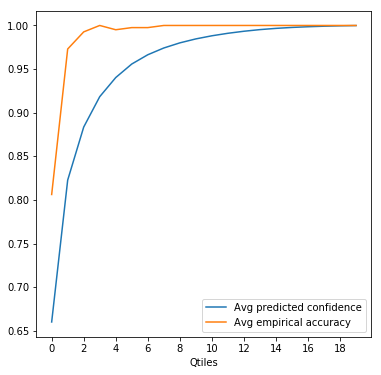

In [0]:
# Train calibration plot
plot_calibration_curve(
  forecasts = np.max(train_predictions_all, axis=1),
  targets = np.equal(np.argmax(train_predictions_all, axis=1), np.argmax(y_train, axis=1)),
  nbuckets=20)


('Total number of examples', 1440)
('Total Calibration Error', 0.028503322725782394)
('Total Sharpness', 0.016009761143040646)
('Total Target variance', 0.20061728395061731)
('Total L2 loss (Target variance + Calibration error - Sharpness)', 0.21338208)
('Total Accuracy', 0.7222222222222222)


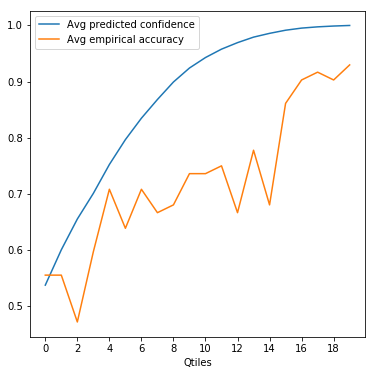

In [0]:
# Validation calibration plot
plot_calibration_curve(
  forecasts = np.max(validation_predictions_all, axis=1),
  targets = np.equal(np.argmax(validation_predictions_all, axis=1), np.argmax(y_validation, axis=1)),
  nbuckets=20)


## Extracting Invariant Candidates

### Build the Decision Tree

In [0]:
def eval_estimator(estimator, suffixes, orig_model_predictions, gt_predictions):
  estimator_predictions = estimator.predict(suffixes)
  acc = (estimator_predictions == gt_predictions)
  agreement = (estimator_predictions == orig_model_predictions)
  print "Estimator accuracy", 1.0*np.sum(acc)/len(suffixes)
  print "Estimator agreement", 1.0*np.sum(agreement)/len(suffixes)

In [0]:
# Basic decision tree
print "Num training examples", len(x_train)
print "Size of each suffix", len(train_suffixes[0])

basic_estimator = tree.DecisionTreeClassifier()
basic_estimator = basic_estimator.fit(train_suffixes, train_predictions,)
print ("Training evaluation")
eval_estimator(basic_estimator, train_suffixes, train_predictions, np.argmax(y_train, axis=1))
print ("Validation evaluation")
eval_estimator(basic_estimator, validation_suffixes, validation_predictions, np.argmax(y_validation, axis=1))

Num training examples 8156
Size of each suffix 192
Training evaluation
Estimator accuracy 0.852623835213
Estimator agreement 0.861329082884
Validation evaluation
Estimator accuracy 0.621527777778
Estimator agreement 0.745138888889


In [0]:
# Fine-grained predictions decision tree
fine_grained_predictions = 10*np.argmax(y_train, axis=1) + train_predictions
if 10 in fine_grained_predictions or 1 in fine_grained_predictions:
  print 'Misclassified in training data' 
else:
  print 'No misclassified in training data'
fine_grained_estimator = tree.DecisionTreeClassifier()
fine_grained_estimator = fine_grained_estimator.fit(train_suffixes, fine_grained_predictions)
print fine_grained_predictions

No misclassified in training data
[ 0  0  0 ... 11 11  0]


### Examine clusters/invariants

In [0]:
def describe_input(i, training=True):
  #print "Input:", x_train[i]
  print "Input in words:", x_text_train[i]
  print "Groundtruth:", np.argmax(y_train,axis=1)[i]
  print "Prediction:", train_predictions[i]
  print "Fine-grained prediction", 10*np.argmax(y_train, axis=1)[i] + train_predictions[i]
  #show_mnist_img(mnist.train.images[i])
  
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  return np.where((train_suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True

def is_misclassified(i):
  return train_predictions[i] != np.argmax(y_train,axis=1)[i]

def get_invariant(estimator, ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = x_train[ref_id]
  ref_suffix = train_suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig

def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print "Obtained all paths"
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants

def describe_cluster(cluster, neuron_ids):
  neuron_sig = train_suffixes[cluster[0]][neuron_ids]
  print "Num neurons in invariant", len(neuron_ids)
  print "Neuron id and signature", zip(neuron_ids, neuron_sig)
  print "Cluster size: ", len(cluster)
  print "Num misclassified", len([i for i in cluster if is_misclassified(i)])

def describe_all_invariants(all_invariants):
  df = []
  for cl, invs in all_invariants.iteritems():
    # Note the number of invariants, and size of the largest invariant cluster
    df.append([cl, sum([inv[2] for inv in invs]), len(invs), len([inv for inv in invs if inv[2]>=10]), invs[0][2]])
  df = pd.DataFrame(df, columns=['Prediction Class', 'Num Instances', 'Num Invariants', 'Num Invariants with cluster size >= 10', 'Size of largest invariant cluster'])
  return df

import operator
def get_invariants_with_confidence(estimator, suffixes, orig_model_predictions, gt_predictions):
  # Return a map from leaf nodes to the corresponding accuracy of the inputs (from suffixes) hitting the leaf.
  leaf_nodes = estimator.apply(suffixes)
  estimator_predictions = estimator.predict(suffixes)
  invs = {}
  # We refer to each invariant by corresponding leaf node id.
  for i, l in enumerate(leaf_nodes):
    if l not in invs:
      invs[l] = []
    invs[l].append(i)
  invs_with_confidence = {l: [len(inv), np.sum(estimator_predictions[inv] == gt_predictions[inv])] for l, inv in invs.iteritems()}
  return invs_with_confidence


In [0]:
# Examine cluster/invariants containing a given reference input
# ref_id is the index of the reference input
ref_id =  0
print "### Reference Sentence ###"
describe_input(ref_id)
#TODO Convert reference sentence back to words
print "### Cluster ###"
cluster, neuron_ids, neuron_sig = get_invariant(basic_estimator, ref_id)
describe_cluster(cluster, neuron_ids)



### Reference Sentence ###
Input in words: demands too much of most viewers
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
### Cluster ###
Num neurons in invariant 5
Neuron id and signature [(160, 0), (96, 0), (114, 1), (164, 0), (32, 1)]
Cluster size:  48
Num misclassified 0


In [0]:
# Get all invariants
be_all_invariants = get_all_invariants(basic_estimator)
#fge_all_invariants = get_all_invariants(fine_grained_estimator)
# Print invariant stats
df = describe_all_invariants(be_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print "Total num invariants with cluster size >= 10:", df['Num Invariants with cluster size >= 10'].sum()
print df.to_string(index=False)


100%|██████████| 835/835 [00:00<00:00, 275745.52it/s]

Obtained all paths
Total num invariants: 835
Total num invariants with cluster size >= 10: 87
 Prediction Class  Num Instances  Num Invariants  Num Invariants with cluster size >= 10  Size of largest invariant cluster
 0                 2080           352             44                                      206                              
 1                 2515           432             43                                      444                              
-1                -51             51              0                                      -1                                


In [0]:
invs_with_confidence_validation = get_invariants_with_confidence(basic_estimator, validation_suffixes, validation_predictions, np.argmax(y_validation, axis=1))
invs_with_confidence_train = get_invariants_with_confidence(basic_estimator, train_suffixes, train_predictions, np.argmax(y_train, axis=1))

## Confidence Analysis

In [0]:
def get_confidence_scores(estimator, suffixes, invs_with_confidence):
  # invs_with_confidence is a map from all nodes in the tree to the corresponding
  # accuracy based on valiation inputs that visit the leaf node
  leaf_nodes = estimator.apply(suffixes)
  conf_scores = []
  for  
  return invs_with_confidence[leaf_nodes]

In [0]:
def plot_bars(ax, bar_vals, bar_names, ptiles, baseline_val=None, baseline_label=None, width=0.2):
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Proportion of Examples")
  #ax.set_ylim((min([min(b) for b in bar_vals])-0.05, 1.1))
  # ax.set_title(title)
  # TODO: why 'plt' below and not 'ax'?
  ind = np.arange(len(ptiles))
  ax.set_xticks(ind)
  ax.set_xticklabels(["%d%%"%(100-ptile) for ptile in ptiles])
  if baseline_val != None:
    ax.axhline(y=baseline_val, color='b', linestyle='-', label=baseline_label)
  
  colors = ['red', 'blue', 'yellow', 'green']
  bars = []
  for i, b in enumerate(bar_vals):
    assert len(b) == len(ptiles)
    bars.append(ax.bar(ind+i*width, b, width=width, color=colors[i]))
  ax.legend(bars, bar_names)

In [0]:
import matplotlib.pyplot as plt

def show_confidence_plot(conf_scores, conf_score_names, orig_model_predictions, gt_predictions, ptiles):
  def get_acc_trend(score, ptiles):
    acc_trend = []
    for ptile in ptiles:
      above_ptile = (score >= np.percentile(score, ptile))
      acc_trend.append(1.0*np.sum(orig_correct*above_ptile)/np.sum(above_ptile))
    return acc_trend   
  orig_correct = (orig_model_predictions == gt_predictions)
  acc_trends = []
  for score in conf_scores:
    acc_trends.append(get_acc_trend(score, ptiles))
  fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
  plot_bars(
      ax,
      acc_trends,
      conf_score_names,
      ptiles,
  )
  plt.show(fig)


conf_score = get_confidence_scores(basic_estimator, test_suffixes, invs_with_confidence_validation)
#conf_score = get_basic_estimator_confidence(basic_estimator_flatten, validation_suffixes)
#conf_score_dense1 = get_basic_estimator_confidence(basic_estimator_dense1, test_suffixes_dense1)
#conf_score_dense2 = get_basic_estimator_confidence(basic_estimator_dense2, test_suffixes_dense2)
prediction_score = test_predictions_all.max(axis=1)

TypeError: ignored

In [0]:
conf_scores

array([0.92857143, 0.        , 0.5210356 , ..., 0.        , 0.        ,
       0.        ])

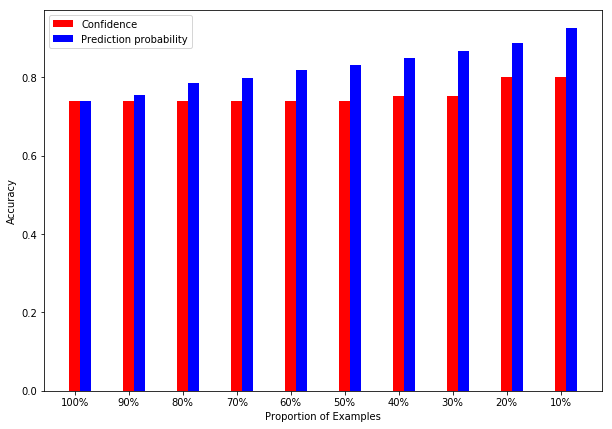

In [0]:
show_confidence_plot(
  [conf_score, prediction_score],
  ['Confidence', 'Prediction probability'],
  test_predictions,
  np.argmax(y_test, axis=1),
  10*np.arange(10))

### Examine all invariants

In [0]:
neuron_ids, neuron_sig, csize = be_all_invariants[0][1]
print csize
print neuron_ids, neuron_sig
cluster = get_suffix_cluster(neuron_ids, neuron_sig)
describe_cluster(cluster, neuron_ids)
#exp_neuron_ids = [i for i, x in enumerate(np.sum(train_suffixes[cluster], axis=0)) if x == len(cluster) or x == 0]
#exp_neuron_sig = [1 if x == len(cluster) else 0 for i, 5x in enumerate(np.sum(train_suffixes[cluster], axis=0)) if x == len(cluster) or x == 0]
#print exp_neuron_ids
#print exp_neuron_sig

117
[145, 128, 28, 133, 168, 97, 138, 155, 33, 51, 92] [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Num neurons in invariant 11
Neuron id and signature [(145, 1), (128, 1), (28, 1), (133, 1), (168, 1), (97, 1), (138, 0), (155, 1), (33, 1), (51, 1), (92, 1)]
Cluster size:  117
Num misclassified 1


In [0]:
def get_cluster_terms(neuron_ids, neuron_sig, label):
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  cluster_terms = []
  for cid in cluster[:100]:
    inp = x_train[cid]
    #print x_text_train[cid]
    inp_terms = get_tokens(inp)
    terms = []
    for i, nid in enumerate(neuron_ids):
      if neuron_sig[i] == 0:
        # Ignore off neurons
        continue
      attrs = np.sum(conductance(inp, label, neuron_id=nid), axis=1)
      terms.append(inp_terms[np.argmax(np.abs(attrs))])
    #print set(terms)
    cluster_terms.append(set(terms)) # unique the set of important terms for one input
  return cluster_terms

def get_top_terms(cluster_terms, top_k=10):
  cluster_terms_flat = []
  for t in cluster_terms:
    cluster_terms_flat += t
  unique_terms, counts = np.unique(cluster_terms_flat, return_counts=True)
  return sorted(zip(unique_terms, counts), key=lambda x: x[1], reverse=True)[:top_k]

In [0]:
for label, invariants in be_all_invariants.iteritems():
  if label == -1:
    continue
  print "Label", label
  for neuron_ids, neuron_sig, csize in invariants:
    if csize < 100:
      continue
    cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    print "Cluster size", csize
    print np.average(train_predictions_all[cluster,:], axis=0)
    print ""

Label 0
Cluster size 1633
[ 51.250584 -49.115444]

Cluster size 674
[ 52.25189 -48.74094]

Cluster size 202
[ 51.993885 -47.60359 ]

Cluster size 200
[ 29.308498 -28.7283  ]

Cluster size 191
[ 33.39221  -32.888866]

Cluster size 152
[ 24.131413 -23.90809 ]

Cluster size 125
[ 55.23593  -50.367485]

Cluster size 122
[ 28.208082 -28.211946]

Cluster size 113
[ 21.779911 -21.95055 ]

Cluster size 112
[ 35.54445 -34.27198]

Label 1
Cluster size 1773
[-40.143703  44.34813 ]

Cluster size 924
[-39.821163  45.094048]

Cluster size 254
[-35.75834   41.171795]

Cluster size 215
[-18.033909  19.225588]

Cluster size 175
[-21.267319  22.674997]

Cluster size 116
[-17.60919   19.406355]



In [0]:
label = 0
for label, invariants in be_all_invariants.iteritems():
  if label == -1:
    continue
  print "Label", label
  for neuron_ids, neuron_sig, csize in invariants[:5]:
    cluster_terms = get_cluster_terms(neuron_ids, neuron_sig, label)
    print "Cluster size", csize
    print get_top_terms(cluster_terms)
    print ""

Label 0
Cluster size 1633
[(u'is', 4), (u'two', 4), (u'bad', 3), (u'every', 3), (u'feels', 3), (u'the', 3), (u'truly', 3), (u'clich', 2), (u'designed', 2), (u'did', 2)]

Cluster size 674
[(u'the', 9), (u'one', 7), (u'so', 4), (u'a', 3), (u'bad', 3), (u'benigni', 3), (u'flat', 3), (u'it', 3), (u'mediocre', 3), (u'movie', 3)]

Cluster size 202
[(u'of', 6), (u'the', 6), (u'it', 5), (u'a', 4), (u'an', 3), (u'dull', 3), (u'fails', 3), (u'funny', 3), (u'bad', 2), (u'bang', 2)]

Cluster size 200
[(u'bad', 5), (u'no', 5), (u'not', 4), (u'too', 4), (u'is', 3), (u'predictable', 3), (u'tedious', 3), (u'worst', 3), (u'director', 2), (u'gets', 2)]

Cluster size 191
[(u'is', 12), (u'too', 7), (u"n't", 6), (u'it', 5), (u'by', 4), (u'for', 4), (u'this', 4), (u'looking', 3), (u'me', 3), (u'seems', 3)]

Label 1
Cluster size 1773
[(u'and', 9), (u'its', 5), (u'culture', 4), (u'heart', 4), (u'of', 4), (u'way', 4), (u'chilling', 3), (u'deeply', 3), (u'funny', 3), (u'life', 3)]

Cluster size 924
[(u'with', 8

In [0]:
  df_data = [[-1, -1, visualize_token_attrs(get_tokens(x_train[id]), ig_attrs).data]]
  vis = visualize_conductances(x_train[id], train_predictions[id], neuron_ids)
  for i, v in enumerate(vis):
    df_data.append([neuron_ids[i], neuron_sig[i], v.data])
  df = pd.DataFrame(df_data, columns=['Neuron', 'Sig', 'Conductance'])
  display(HTML(df.to_html(escape=False, max_rows=None, max_cols=None, index=False)))

In [0]:
neuron_ids, neuron_sig, csize = be_all_invariants[1][0]
print csize
cluster = get_suffix_cluster(neuron_ids, neuron_sig)
cluster_predictions = get_prediction(x_train[cluster], tensor=y_conv, batch_size=10)
describe_cluster(cluster, neuron_ids)
# Visualize  10 inputs in the cluster
for i, ind in enumerate(cluster[:20]):
  print x_text_train[ind]
  print cluster_predictions[i]
  # describe_input(i) 

In [0]:
# Get all fine_grained_estimator invariants
fge_all_invariants = get_all_invariants(fine_grained_estimator)
# Print invariant stats
df = describe_all_invariants(fge_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print "Total num invariants with cluster size >= 10:", df['Num Invariants with cluster size >= 10'].sum()
print df.to_string(index=False)



100%|██████████| 901/901 [00:00<00:00, 218002.19it/s]

Obtained all paths
Total num invariants: 901
Total num invariants with cluster size >= 10: 190
Prediction Class  Num Instances  Num Invariants  Num Invariants with cluster size >= 10  Size of largest invariant cluster
               0           4780             449                                      95                                352
              11           4816             452                                      95                                399


### Analyzing clusters of misclassified inputs

In [0]:
# Examine the cluster for a misclasification (Groundtruth: 4, Prediction: 49)
invs = fge_all_invariants[00]
neuron_ids, neuron_sig, _ = invs[0]
cluster = get_suffix_cluster(neuron_ids, neuron_sig)
describe_cluster(cluster, neuron_ids)

# Visualize  10 inputs in the cluster
for i in cluster[:10]:
  describe_input(i)
  # show_img(visualize_conductances(mnist.train.images[i], train_predictions[i], neuron_ids, only_on=False))

Num neurons in invariant 17
Neuron id and signature [(54, 0), (389, 0), (457, 1), (1462, 0), (901, 0), (4632, 0), (49, 0), (1709, 0), (527, 0), (2639, 0), (306, 0), (1620, 0), (4285, 0), (1476, 0), (3532, 0), (219, 0), (178, 0)]
Cluster size:  352
Num misclassified 0
Input in words: a rote exercise in both animation and storytelling
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
Input in words: two hours of junk
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
Input in words: in execution , this clever idea is far less funny than the original , killers from space
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
Input in words: i have to admit that i am baffled by jason x
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
Input in words: this thing is just garbage
Groundtruth: 0
Prediction: 0
Fine-grained prediction 0
Input in words: the idea is more interesting than the screenplay , which lags badly in the middle and lurches between not very funny comedy , uncon

## Test Accuracy Improvements

In [0]:
# We use the fine_grained_estimator to check if an input belongs
# to a pure cluster (i.e., prediction id of the form 10*label + label).
# If so, we declare the network's prediction as a "condident prediction".
# We measure the accuracy of confident_predictions.
fine_grained_estimator_test_predictions = fine_grained_estimator.predict(test_suffixes)
fine_grained_estimator_leaf_nodes = fine_grained_estimator.apply(test_suffixes)

In [0]:
def test_accuracy_for_label(label):
  def get_confidence():
    is_confident = (fine_grained_estimator_test_predictions == 10*label + label)
    sufficient_samples = fine_grained_estimator.tree_.n_node_samples[fine_grained_estimator_leaf_nodes] >= 5
    is_confident *= sufficient_samples
    return is_confident
  # Following are boolean array. For e.g., with_label[i] is True if
  # image i has the given label
  with_label = (np.argmax(y_test, axis=1) == label)
  print with_label
  is_correct = (test_predictions == np.argmax(y_test, axis=1))
  with_label_and_correct = with_label*is_correct
  is_confident = get_confidence()
  with_label_and_correct_and_confident = with_label_and_correct*is_confident
  with_label_and_confident = with_label*is_confident

  total = np.sum(with_label)
  num_conf = np.sum(with_label_and_confident) 
  num_correct = np.sum(with_label_and_correct)
  num_correct_conf = np.sum(with_label_and_correct_and_confident)
  return total, num_conf, num_correct, num_correct_conf

In [0]:
df = []
grand_total = 0
grand_correct = 0
grand_conf = 0
grand_correct_conf = 0
for i in range(10):
  total, num_conf, num_correct, num_correct_conf = test_accuracy_for_label(i)
  if total == 0:
    continue
  grand_total += total
  grand_conf += num_conf
  grand_correct += num_correct
  grand_correct_conf += num_correct_conf
  acc = 1.0*num_correct/total
  conf_acc = 1.0*num_correct_conf/num_conf
  df.append([i, total, num_conf, acc, conf_acc])
df = pd.DataFrame(df, columns=['Label', 'Instances', 'ConfidentInstances',  'Acc', 'ConfidentAcc',])
display(df)
print "Total Instances", grand_total
print "Num Confident Instances", grand_conf
print "Orig Accuracy", 1.0*grand_correct/grand_total
print "Confident Accuracy", 1.0*grand_correct_conf/grand_conf

[ True False  True ... False  True False]
[False  True False ...  True False  True]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


,Label,Instances,ConfidentInstances,Acc,ConfidentAcc
0,0,551,304,0.729583,0.924342
1,1,515,341,0.724272,0.882698


Total Instances 1066
Num Confident Instances 645
Orig Accuracy 0.727016885553
Confident Accuracy 0.902325581395


## Visualizing the Decision Tree

In [0]:
!apt-get install graphviz
!pip install graphviz
import graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 2 not upgraded.
Need to get 4,154 kB of

In [0]:
dot_data = tree.export_graphviz(basic_estimator, out_file=None) 
graph = graphviz.Source(dot_data)  
graph

In [0]:
dot_data = tree.export_graphviz(fine_grained_estimator, out_file=None) 
graph = graphviz.Source(dot_data)  
graph